# Sentinel-1 

## Accessing Sentinel-1 data on Microsoft Planetary Computer

1. Register for a Planetary Computer account, then sign into the Developer Portal: https://planetarycomputer.developer.azure-api.net/  ([more info here](https://planetarycomputer.microsoft.com/docs/concepts/sas/#supplying-a-subscription-key))
2. Under "Subscriptions", you should see "Primary key" - copy the primary API key (this page may take a while to load):
3. On the DEA Sandbox, launch a new terminal
4. Type `planetarycomputer configure`. When prompted, paste in your copied API key
5. Now you should be able to load Sentinel-1 data via the Sandbox

In [1]:
import numpy as np
import pystac_client
import planetary_computer
import odc.stac
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

from datacube.utils.masking import mask_invalid_data
from dea_tools.plotting import xr_animation
from dea_tools.dask import create_local_dask_cluster
client = create_local_dask_cluster(return_client=True)


/env/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40979 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/40979/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/40979/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38853,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/40979/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:46833,Total threads: 31
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/36783/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:33855,


In [16]:
# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
study_area = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4)
bbox = study_area.boundingbox

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [17]:
# Open a client pointing to the Microsoft Planetary Computer data catalogue
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Search for data
# bbox = (153.110, -26.841, 153.153, -26.803)  
search = catalog.search(
    collections=["sentinel-1-rtc"], bbox=bbox, datetime="2015-01-01/2023-09-09"
)
items = search.item_collection()
print(f"Found {len(items)} items")

# Lazily load Sentinel-1 data with ODC STAC
ds = odc.stac.load(
    items,
    bbox=bbox,
    bands=["vv", "vh"],
    crs="utm",
    resampling="cubic",
    resolution=10,
    groupby="solar_day",
    chunks={},
)

# Mask nodata and load into memory with Dask
ds = mask_invalid_data(ds)
ds.load()

Found 492 items


<xarray.Dataset>
Dimensions:      (y: 209, x: 243, time: 492)
Coordinates:
  * y            (y) float64 6.172e+06 6.172e+06 6.172e+06 ... 6.17e+06 6.17e+06
  * x            (x) float64 3.039e+05 3.039e+05 ... 3.063e+05 3.063e+05
    spatial_ref  int32 32756
  * time         (time) datetime64[ns] 2015-01-07T19:15:32.623713 ... 2023-09...
Data variables:
    vv           (time, y, x) float32 0.1312 0.1134 0.04292 ... 0.1867 0.1198
    vh           (time, y, x) float32 0.01861 0.03181 ... 0.06389 0.05734

In [18]:
from skimage.filters import unsharp_mask
from skimage.exposure import rescale_intensity
import cmocean

funcs_list = [
    
              # Rescale values to range accepted by `xr_animation`
              rescale_intensity,
    
              # Apply different levels of unsharp masking to enhance
              # overall dynamic range, and improve fine scale detail
              lambda x: unsharp_mask(x, radius=20, amount=0.5),

             ]


# Animate decibels
ds_db = 10 * np.log10(ds)
ds_rolling = ds_db.rolling(time=33, center=True, min_periods=1).median()

Exporting animation to s1_vv_db.mp4


  0%|          | 0/492 (0.0 seconds remaining at ? frames/s)

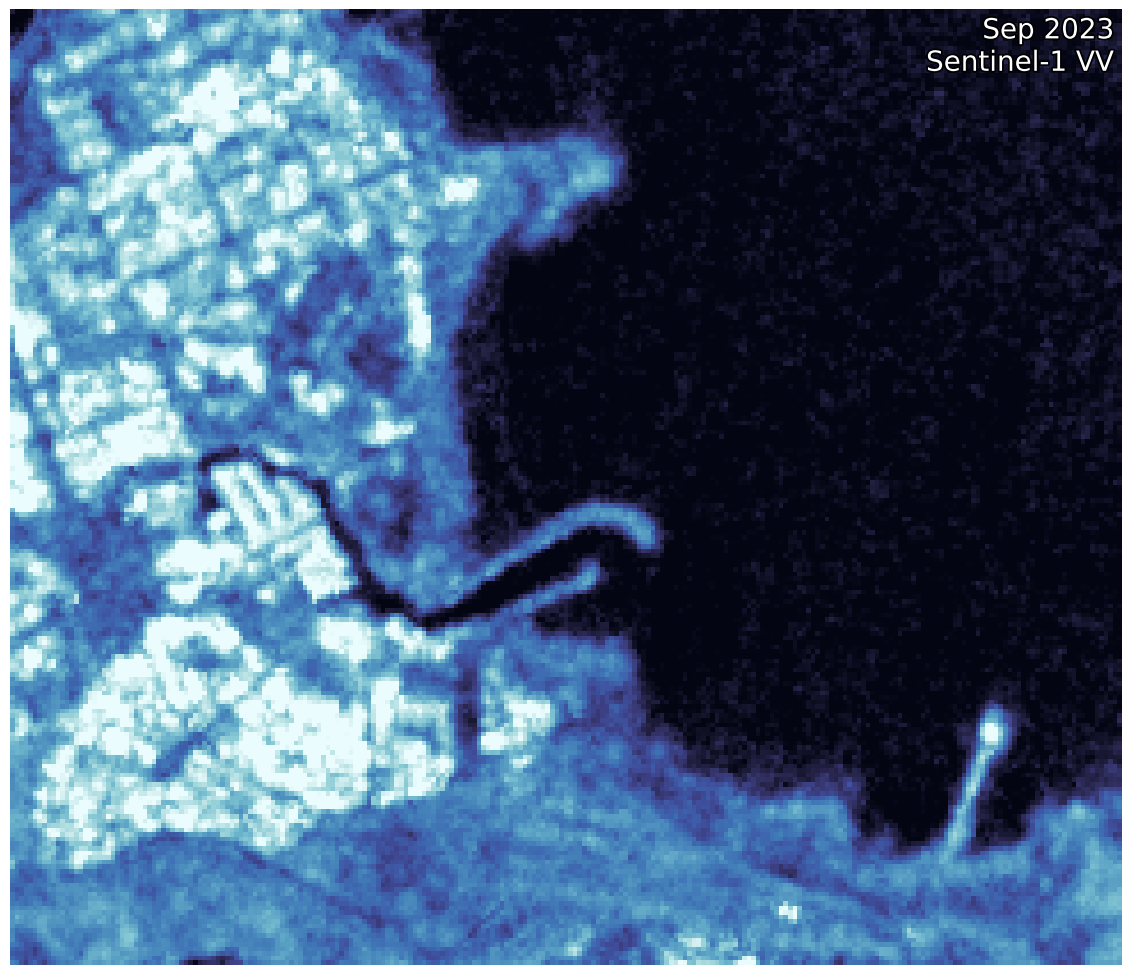

In [19]:
xr_animation(
    ds_rolling,
    bands="vv",
    show_text="Sentinel-1 VV",
    interval=25,
    width_pixels=800,
    percentile_stretch=(0.15, 0.97),
    # limit=4,
    imshow_kwargs={"cmap": cmocean.cm.ice},
    # image_proc_funcs=funcs_list,
    show_date="%b %Y",
    output_path="s1_vv_db.mp4",
    show_colorbar=False,
)

Exporting animation to s1_vv_fc.mp4


  0%|          | 0/492 (0.0 seconds remaining at ? frames/s)

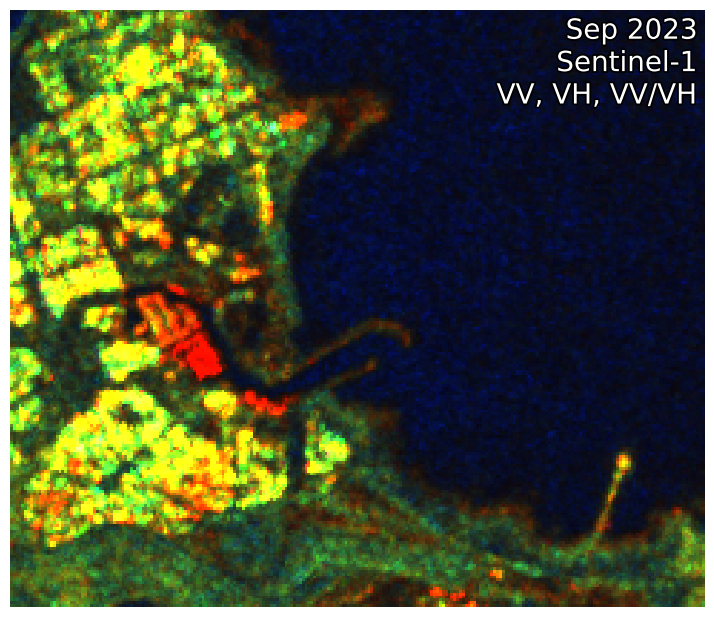

In [20]:
funcs_list = [
    
              # Rescale values to range accepted by `xr_animation`
              rescale_intensity,
    
              # Apply different levels of unsharp masking to enhance
              # overall dynamic range, and improve fine scale detail
              lambda x: unsharp_mask(x, radius=20, amount=0.1),

             ]

# False colour
ds["vh/vv"] = ds.vh / ds.vv
ds_norm = ds / ds.median()
ds_rolling = ds_norm.rolling(time=13, center=True, min_periods=1).median()
xr_animation(
    ds_rolling,
    bands=["vv", "vh", "vh/vv"],
    interval=40,
    percentile_stretch=(0.00, 0.97),
    # limit=5,
    # image_proc_funcs=funcs_list,
    show_date="%b %Y",
    show_text="Sentinel-1\nVV, VH, VV/VH",
    output_path="s1_vv_fc.mp4",
)

In [1]:
!curl -Is https://api.planet.com/data/v1

HTTP/2 200 
content-type: application/json
date: Tue, 12 Sep 2023 00:11:30 GMT
strict-transport-security: max-age=15724800; includeSubDomains
x-planet-trace-id: b255e0f8-3190-487e-8cb2-9a87603dde8d
via: 1.1 edge, 1.1 google
alt-svc: h3=":443"; ma=2592000,h3-29=":443"; ma=2592000



In [25]:
!curl -Is https://landsat.usgs.gov

HTTP/1.1 301 Moved Permanently
Server: CloudFront
Date: Mon, 11 Sep 2023 07:02:49 GMT
Content-Type: text/html
Content-Length: 167
Connection: keep-alive
Location:]8;;https://www.usgs.gov/landsat-missions\ https://www.usgs.gov/landsat-missions
]8;;\X-Cache: Redirect from cloudfront
Via: 1.1 be7f6ce4397843276657a8babac08b6e.cloudfront.net (CloudFront)
X-Amz-Cf-Pop: DEN52-C1
Alt-Svc: h3=":443"; ma=86400
X-Amz-Cf-Id: t0Xwl3_Lbg6L8hWPmuUqM1loGEz9_78KQruS1OygYT94XjgYt2s6QA==
Set-Cookie: cookiesession1=678A3E66A2D912A694EAEDDE7C002986;Expires=Tue, 10 Sep 2024 07:02:49 GMT;Path=/;HttpOnly
Strict-Transport-Security: max-age=31536000; includeSubDomains; preload

